## Import Required Packages

In [19]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

## Import the The Data


In [20]:
data_for_model_train = pd.read_csv("D:\\DSI\\data\\kaggle_introvert_data\\train.csv")
data_for_model_test = pd.read_csv("D:\\DSI\\data\\kaggle_introvert_data\\test.csv")

In [21]:
# Dropping the ID Column

data_for_model_train.drop("id", axis = 1, inplace=True)
data_for_model_test.drop("id", axis = 1, inplace=True)

## Shuffle Data


In [22]:
# Shuffle the data to prevent Bias and Overfitting

data_for_model_train = shuffle(data_for_model_train, random_state=42)

## Class Balance

In [23]:
# Investigating the class balance of the output

data_for_model_train["Personality"].value_counts(normalize = True)

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64

## Deal with Missing Values

In [24]:
data_for_model_train.isna().sum()

Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [25]:
# Using the KNN Imputer for imputing the missing values with "distance" as the weightage

from sklearn.impute import KNNImputer
knn_imputer_x = KNNImputer(weights="distance")
knn_imputer_y = KNNImputer(weights="distance")

In [26]:
# Splitting the X and y data

X_train = data_for_model_train.drop(["Personality"], axis=1)
y_train = data_for_model_train["Personality"]

## One Hot Encoding for the categorical variables

In [27]:
# Encoding the X_train and X_test and y_train values

X_categorical_vars = ["Stage_fear", "Drained_after_socializing"]
y_categorical_vars = ["Personality"]
one_hot_encoder_x = OneHotEncoder(sparse_output=False, drop = "first")
one_hot_encoder_y = OneHotEncoder(sparse_output=False, drop = "first")
X_train_encoded = one_hot_encoder_x.fit_transform(X_train[X_categorical_vars])
X_test_encoded = one_hot_encoder_x.transform(data_for_model_test[X_categorical_vars])
y_train_encoded = one_hot_encoder_y.fit_transform(y_train.values.reshape(-1, 1))

X_encoder_feature_names = one_hot_encoder_x.get_feature_names_out(X_categorical_vars)
y_encoder_feature_names = one_hot_encoder_y.get_feature_names_out(y_categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded, columns = X_encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True),X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(X_categorical_vars, axis = 1, inplace = True)

y_train_encoded = pd.DataFrame(y_train_encoded, columns = y_encoder_feature_names)
y_train = pd.concat([y_train.reset_index(drop=True),y_train_encoded.reset_index(drop=True)], axis = 1)
y_train.drop(y_categorical_vars, axis = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = X_encoder_feature_names)
X_test = pd.concat([data_for_model_test.reset_index(drop=True),X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(X_categorical_vars, axis = 1, inplace = True)

## Imputing the missing values using KNN Imputer for "X" and "y" values

In [28]:
X_train_imputed = pd.DataFrame(knn_imputer_x.fit_transform(X_train), columns=X_train.columns)
y_train_imputed = pd.DataFrame(knn_imputer_y.fit_transform(y_train), columns=y_train.columns)
X_test_imputed = pd.DataFrame(knn_imputer_x.transform(X_test), columns=X_test.columns)

## Model Training

In [29]:
classifier = RandomForestClassifier(random_state=42, n_estimators=1000, max_features=7)
classifier.fit(X_train_imputed, y_train_imputed.squeeze())

,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,7
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Feature Importance

In [30]:
feature_importances = pd.DataFrame(classifier.feature_importances_)
feature_names = pd.DataFrame(X_train_imputed.columns)

feature_importance_summary = pd.concat([feature_names, feature_importances], axis = 1)

In [31]:
feature_importance_summary.columns = ["input_variables", "feature_importance"]
feature_importance_summary.sort_values(by="feature_importance", inplace=True)

## Plotting the important features that were using model training

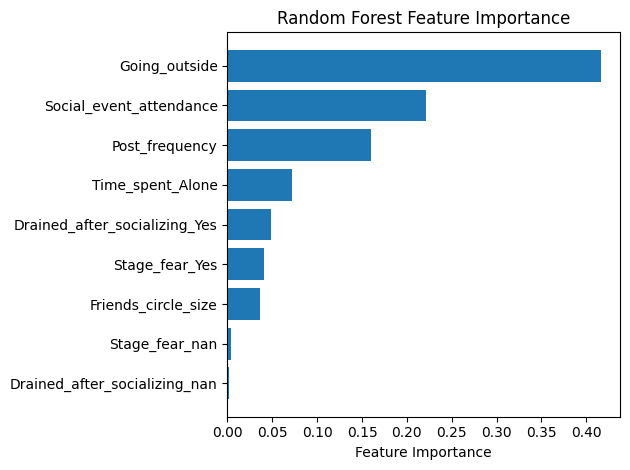

In [32]:
plt.barh(feature_importance_summary["input_variables"], feature_importance_summary["feature_importance"])
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature Importance") 
plt.tight_layout()
plt.show()

## Dropping the un-important features that were found during the initial training and retraining the model

In [33]:
X_train_imputed.drop(["Stage_fear_nan", "Drained_after_socializing_nan"], axis=1, inplace=True)


classifier = RandomForestClassifier(random_state=42, n_estimators=1000, max_features=7)
classifier.fit(X_train_imputed, y_train_imputed.squeeze())

,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,7
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Predictions

In [34]:
# Dropping the un-important features that were found from Feature Importance

X_test_imputed.drop(["Stage_fear_nan", "Drained_after_socializing_nan"], axis=1, inplace=True)

# Making predictions
y_pred_class = classifier.predict(X_test_imputed)

## Saving the predictions into a CSV file in the requested format

In [35]:
import pandas as pd

# Load the test file
test_df = pd.read_csv('D:\\DSI\\data\\kaggle_introvert_data\\test.csv')



# Map predictions back to string labels
label_map = {0: "Extrovert", 1: "Introvert"}
personality_pred = [label_map[y] for y in y_pred_class]

# Create the output DataFrame
output_df = pd.DataFrame({
    'id': test_df['id'],
    'Personality': personality_pred
})

# Save to CSV
output_df.to_csv('submission.csv', index=False)